## 13. This question should be answered using the Weekly data set, which is part of the ISLP package. This data is similar in nature to the Smarket data from this chapter’s lab, except that it contains 1,089 weekly returns for 21 years, from the beginning of 1990 to the end of 2010.

#### (a) Produce some numerical and graphical summaries of the Weekly data. Do there appear to be any patterns?

In [9]:
import pandas as pd
import numpy as np

#vix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

##check screeshot of feb 6th
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

#load StatsModel API
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [10]:
pip install ISLP

  Obtaining dependency information for ISLP from https://files.pythonhosted.org/packages/f4/d5/daa84d67cb6d29e6ce1e52eb74da029296fb1290a3b278bfa5c8ba67b7d2/ISLP-0.3.22-py3-none-any.whl.metadata
  Obtaining dependency information for lifelines from https://files.pythonhosted.org/packages/b3/98/868d6b60a6a8847a53bca3b15b0e057fb3ed6395e5852f0c0c55bbaaa928/lifelines-0.28.0-py3-none-any.whl.metadata
  Obtaining dependency information for pygam from https://files.pythonhosted.org/packages/ea/a7/d7037173f7c39fd114ca7bc9757149bdfbe2951b5c2cba08038c24e55e10/pygam-0.9.1-py3-none-any.whl.metadata
  Obtaining dependency information for pytorch-lightning from https://files.pythonhosted.org/packages/8b/1a/bf51e48e9c60e892ea97dc8198d8a32cba94d014c52baca1c93599bfe30c/pytorch_lightning-2.2.0.post0-py3-none-any.whl.metadata
  Obtaining dependency information for torchmetrics from https://files.pythonhosted.org/packages/cd/23/4bb4c1b78b57682a1309974a29bfdcbfa6fcf5476e698a4f0f22affa3799/torchmetrics-1.3.1

In [140]:
from ISLP import load_data
Weekly = load_data('Weekly').dropna()
Weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [13]:
# Check for missing values
Weekly.isna().any()

Year         False
Lag1         False
Lag2         False
Lag3         False
Lag4         False
Lag5         False
Volume       False
Today        False
Direction    False
dtype: bool

In [15]:
Weekly["Direction"].value_counts()

Up      605
Down    484
Name: Direction, dtype: int64

#### (b) Use the full data set to perform a logistic regression with Direction as the response and the five lag variables plus Volume as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?

In [16]:
feature_types = Weekly.dtypes

# Print the data types of each column
print(feature_types)

Year           int64
Lag1         float64
Lag2         float64
Lag3         float64
Lag4         float64
Lag5         float64
Volume       float64
Today        float64
Direction     object
dtype: object


In [17]:
endog = (Weekly["Direction"] == "Up")
exog = sm.add_constant(Weekly.drop(columns = ["Direction", "Volume", "Today"]))
logit_mod = sm.Logit(endog, exog)
logit_res = logit_mod.fit()
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.682350
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Fri, 23 Feb 2024   Pseudo R-squ.:                0.006713
Time:                        16:48:45   Log-Likelihood:                -743.08
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1228
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.7148     20.380      0.771      0.441     -24.229      55.659
Year          -0.0077      0.010     -0.760      0.447      -0.028       0.012
Lag1          -0.0408      0.026     -1.547      0.122      -0.092       0.011
Lag2           0.0593      0.027      2.216      0.027       0.007       0.112
Lag3          -0.0156      0.027     -0.585      0.559      -0.068       0.037
Lag4          -0.0274      0.026     -1.037      0.300      -0.079       0.024
Lag5          -0.0141      0.026     -0.535      0.593      -0.066       0.038
==============================================================================
"""

#### (c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

In [18]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [25]:
probs = logit_res.predict(exog)
predictions = ["Down"] * len(probs)
predictions = ["Up" if prob > 0.5 else pred for pred, prob in zip(predictions, probs)]

In [26]:
pd.DataFrame(logit_res.pred_table(), columns=["PredDown", "PredUp"], index=["ActualDown", "ActualUp"])

,PredDown,PredUp
ActualDown,58.0,426.0
ActualUp,48.0,557.0


#### (d) Now fit the logistic regression model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).

In [113]:
# 1. Split the Data
train_data = Weekly[Weekly['Year'] <= 2008]
test_data = Weekly[Weekly['Year'] >= 2009]

# 2. Fit Logistic Regression Model
X_train = sm.add_constant(train_data[['Lag2']])
y_train = (train_data['Direction'] == 'Up')
logit_model = sm.Logit(y_train, X_train)
logit_results = logit_model.fit()

# 3. Predictions
X_test = sm.add_constant(test_data[['Lag2']])
y_test = (test_data['Direction'] == 'Up').astype(int)  # Convert Direction to binary
predicted_probs = logit_results.predict(X_test)
predicted_directions = (predicted_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

# 4. Compute Confusion Matrix
confusion_matrix = pd.crosstab(y_test, predicted_directions, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

# 5. Compute Overall Fraction of Correct Predictions
correct_predictions = (y_test == predicted_directions).sum()
total_predictions = len(y_test)
accuracy_logit = correct_predictions / total_predictions
print("Overall Accuracy:", accuracy_logit)

Optimization terminated successfully.
         Current function value: 0.685555
         Iterations 4
Predicted  0   1
Actual          
0          9  34
1          5  56
Overall Accuracy: 0.625


In [42]:

from sklearn.metrics import confusion_matrix

# 1. Split the Data
train_data = Weekly[Weekly['Year'] <= 2008]
test_data = Weekly[Weekly['Year'] >= 2009]

# Check the column names
print(train_data.columns)

# 2. Fit Logistic Regression Model
X_train = sm.add_constant(train_data[['Lag2']])
y_train = (train_data['Direction'] == 'Up').astype(int)  # Convert Direction to binary
logit_model = sm.Logit(y_train, X_train)
logit_results = logit_model.fit()

# 3. Predictions for Test Set
test_exog = sm.add_constant(test_data[['Lag2']])  # Include only the predictor used in training
logit_test_probs = logit_results.predict(test_exog)
logit_test_preds = (logit_test_probs > 0.5).astype(int)

# Convert integer labels back to string labels
logit_test_preds_labels = logit_test_preds.replace({0: 'Down', 1: 'Up'})

# 4. Compute Confusion Matrix for Test Set
confusion_matrix_test = confusion_matrix(test_data['Direction'], logit_test_preds_labels)
confusion_df = pd.DataFrame(confusion_matrix_test, columns=["PredDown", "PredUp"], index=["ActualDown", "ActualUp"])
print(confusion_df)

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.685555
         Iterations 4
            PredDown  PredUp
ActualDown         9      34
ActualUp           5      56


(e) Repeat (d) using LDA.

In [118]:
from sklearn.metrics import confusion_matrix, accuracy_score

# 1. Split the Data
train_data = Weekly[Weekly['Year'] <= 2008]
test_data = Weekly[Weekly['Year'] >= 2009]

# 2. Fit LDA Model
X_train = train_data[['Lag2']]
y_train = train_data['Direction']
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

# 3. Predictions
X_test = test_data[['Lag2']]
y_test = test_data['Direction']
predicted_directions = lda_model.predict(X_test)

# 4. Compute Confusion Matrix
conf_matrix = confusion_matrix(y_test, predicted_directions)
confusion_df = pd.DataFrame(conf_matrix, index=['Actual Down', 'Actual Up'], columns=['Predicted Down', 'Predicted Up'])
print(confusion_df)

# 5. Compute Overall Accuracy
accuracy_lda = accuracy_score(test_data['Direction'], predicted_directions)
print("Overall Accuracy:", accuracy_lda)

             Predicted Down  Predicted Up
Actual Down               9            34
Actual Up                 5            56
Overall Accuracy: 0.625


(f) Repeat (d) using QDA.

In [115]:
# 1. Split the Data
train_data = Weekly[Weekly['Year'] <= 2008]
test_data = Weekly[Weekly['Year'] >= 2009]

# 2. Fit QDA Model
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(train_data[['Lag2']], train_data['Direction'])

# 3. Predictions for Test Set
qda_test_preds = qda_model.predict(test_data[['Lag2']])

# 4. Compute Confusion Matrix for Test Set
confusion_matrix_test = confusion_matrix(test_data['Direction'], qda_test_preds)
confusion_df = pd.DataFrame(confusion_matrix_test, columns=["PredDown", "PredUp"], index=["ActualDown", "ActualUp"])
print("Confusion Matrix:")
print(confusion_df)

# 5. Compute Overall Accuracy
accuracy_qda = accuracy_score(test_data['Direction'], qda_test_preds)
print("Overall Accuracy:", accuracy_qda)

Confusion Matrix:
            PredDown  PredUp
ActualDown         0      43
ActualUp           0      61
Overall Accuracy: 0.5865384615384616


(g) Repeat (d) using KNN with K = 1.

In [116]:
# 1. Split the Data
train_data = Weekly[Weekly['Year'] <= 2008]
test_data = Weekly[Weekly['Year'] >= 2009]

# 2. Fit KNN Model with K = 1
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(train_data[['Lag2']], train_data['Direction'])

# 3. Predictions for Test Set
knn_test_preds = knn_model.predict(test_data[['Lag2']])

# 4. Compute Confusion Matrix for Test Set
confusion_matrix_test = confusion_matrix(test_data['Direction'], knn_test_preds)
confusion_df = pd.DataFrame(confusion_matrix_test, columns=["PredDown", "PredUp"], index=["ActualDown", "ActualUp"])
print("Confusion Matrix:")
print(confusion_df)

# 5. Compute Overall Accuracy
accuracy_knn1 = accuracy_score(test_data['Direction'], knn_test_preds)
print("Overall Accuracy:", accuracy_knn1)

Confusion Matrix:
            PredDown  PredUp
ActualDown        21      22
ActualUp          30      31
Overall Accuracy: 0.5


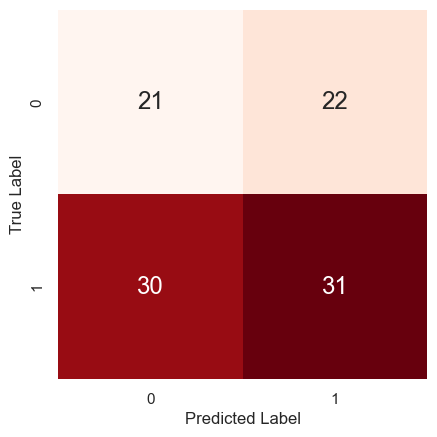

In [105]:
# Make predictions on test data and evaluate the fit
knn_test_preds = knn_model.predict(test_data[['Lag2']])
mat = confusion_matrix(test_data['Direction'], knn_test_preds)
fig, ax = plt.subplots()
sns.heatmap(mat, annot=True, cmap= 'Reds', cbar=False, ax=ax, fmt="g", square=True, annot_kws={"fontsize": "x-large"})
ax.set(xlabel="Predicted Label", ylabel="True Label")
plt.show()

#### (h) Repeat (d) using naive Bayes.

In [117]:
from sklearn.naive_bayes import GaussianNB

# 1. Split the Data
train_data = Weekly[Weekly['Year'] <= 2008]
test_data = Weekly[Weekly['Year'] >= 2009]

# 2. Fit Naive Bayes Model
nb_model = GaussianNB()
nb_model.fit(train_data[['Lag2']], train_data['Direction'])

# 3. Predictions for Test Set
nb_test_preds = nb_model.predict(test_data[['Lag2']])

# 4. Compute Confusion Matrix for Test Set
confusion_matrix_test = confusion_matrix(test_data['Direction'], nb_test_preds)
confusion_df = pd.DataFrame(confusion_matrix_test, columns=["PredDown", "PredUp"], index=["ActualDown", "ActualUp"])
print("Confusion Matrix:")
print(confusion_df)

# 5. Compute Overall Accuracy
accuracy_bay = accuracy_score(test_data['Direction'], nb_test_preds)
print("Overall Accuracy:", accuracy_bay)

Confusion Matrix:
            PredDown  PredUp
ActualDown         0      43
ActualUp           0      61
Overall Accuracy: 0.5865384615384616


#### (i) Which of these methods appears to provide the best results on this data?

In [127]:
from sklearn.model_selection import cross_val_score

# Assuming accuracy_knn1, accuracy_lda, accuracy_logit, accuracy_qda are valid classifier objects
# And knn_test_preds, predicted_directions, logit_test_preds_labels contain predicted labels

d = {
    'KNN': [accuracy_score(test_data['Direction'], knn_test_preds)],
    'LDA': [accuracy_score(test_data['Direction'], predicted_directions)],
    'Logit': [accuracy_score(test_data['Direction'], logit_test_preds_labels)], 
    'QDA': [accuracy_score(test_data['Direction'], qda_test_preds)]
}

df = pd.DataFrame(data=d, index=["Accuracy"]).T.sort_values(by='Accuracy', ascending=False)
df

,Accuracy
LDA,0.625000
Logit,0.625000
QDA,0.586538
KNN,0.500000


#### Ans: The best evaluation metrics are for Logistic regressions and LDA with 62% accuracy.

#### (j) Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.

In [63]:
# 1. Split the Data
train_data = Weekly[Weekly['Year'] <= 2008]
test_data = Weekly[Weekly['Year'] >= 2009]

# 2. Fit Logistic Regression Model
X_train = sm.add_constant(train_data[['Lag3']])
y_train = (train_data['Direction'] == 'Up')
logit_model = sm.Logit(y_train, X_train)
logit_results = logit_model.fit()

# 3. Predictions
X_test = sm.add_constant(test_data[['Lag3']])
y_test = (test_data['Direction'] == 'Up').astype(int)  # Convert Direction to binary
predicted_probs = logit_results.predict(X_test)
predicted_directions = (predicted_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

# 4. Compute Confusion Matrix
confusion_matrix = pd.crosstab(y_test, predicted_directions, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

# 5. Compute Overall Fraction of Correct Predictions
correct_predictions = (y_test == predicted_directions).sum()
total_predictions = len(y_test)
accuracy = correct_predictions / total_predictions
print("Overall Accuracy:", accuracy)

Optimization terminated successfully.
         Current function value: 0.687489
         Iterations 4
Predicted   1
Actual       
0          43
1          61
Overall Accuracy: 0.5865384615384616


In [71]:
from sklearn.metrics import confusion_matrix, accuracy_score

# 1. Split the Data
train_data = Weekly[Weekly['Year'] <= 2008]
test_data = Weekly[Weekly['Year'] >= 2009]

# 2. Fit LDA Model
X_train = train_data[['Lag2', 'Lag4']]  # Include Lag4 as a predictor
y_train = train_data['Direction']
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

# 3. Predictions
X_test = test_data[['Lag2', 'Lag4']]  # Include Lag4 as a predictor
y_test = test_data['Direction']
predicted_directions_lda = lda_model.predict(X_test)

# 4. Compute Confusion Matrix
conf_matrix_lda = confusion_matrix(y_test, predicted_directions_lda)
confusion_df = pd.DataFrame(conf_matrix_lda, index=['Actual Down', 'Actual Up'], columns=['Predicted Down', 'Predicted Up'])
print(confusion_df)

# 5. Compute Overall Accuracy
accuracy_lda = accuracy_score(y_test, predicted_directions_lda)
print("Overall Accuracy:", accuracy_lda)


             Predicted Down  Predicted Up
Actual Down               8            35
Actual Up                 4            57
Overall Accuracy: 0.625


In [72]:
# 1. Split the Data
train_data = Weekly[Weekly['Year'] <= 2008]
test_data = Weekly[Weekly['Year'] >= 2009]

# 2. Fit QDA Model
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(train_data[['Lag4']], train_data['Direction'])

# 3. Predictions for Test Set
qda_test_preds = qda_model.predict(test_data[['Lag4']])

# 4. Compute Confusion Matrix for Test Set
confusion_matrix_test = confusion_matrix(test_data['Direction'], qda_test_preds)
confusion_df = pd.DataFrame(confusion_matrix_test, columns=["PredDown", "PredUp"], index=["ActualDown", "ActualUp"])
print("Confusion Matrix:")
print(confusion_df)

# 5. Compute Overall Accuracy
accuracy = accuracy_score(test_data['Direction'], qda_test_preds)
print("Overall Accuracy:", accuracy)

Confusion Matrix:
            PredDown  PredUp
ActualDown         7      36
ActualUp          12      49
Overall Accuracy: 0.5384615384615384


In [75]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# 1. Split the Data
train_data = Weekly[Weekly['Year'] <= 2008]
test_data = Weekly[Weekly['Year'] >= 2009]

# 2. Create interaction terms
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_train_interact = poly.fit_transform(train_data[['Lag4']])
X_test_interact = poly.transform(test_data[['Lag4']])

# 3. Fit KNN Model with K = 5
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_interact, train_data['Direction'])

# 4. Predictions for Test Set
knn_test_preds = knn_model.predict(X_test_interact)

# 5. Compute Confusion Matrix for Test Set
confusion_matrix_test = confusion_matrix(test_data['Direction'], knn_test_preds)
confusion_df = pd.DataFrame(confusion_matrix_test, columns=["PredDown", "PredUp"], index=["ActualDown", "ActualUp"])
print("Confusion Matrix:")
print(confusion_df)

# 6. Compute Overall Accuracy
accuracy = accuracy_score(test_data['Direction'], knn_test_preds)
print("Overall Accuracy:", accuracy)

Confusion Matrix:
            PredDown  PredUp
ActualDown        19      24
ActualUp          19      42
Overall Accuracy: 0.5865384615384616


In [74]:
from sklearn.naive_bayes import GaussianNB

# 1. Split the Data
train_data = Weekly[Weekly['Year'] <= 2008]
test_data = Weekly[Weekly['Year'] >= 2009]

# 2. Fit Naive Bayes Model
nb_model = GaussianNB()
nb_model.fit(train_data[['Volume']], train_data['Direction'])

# 3. Predictions for Test Set
nb_test_preds = nb_model.predict(test_data[['Volume']])

# 4. Compute Confusion Matrix for Test Set
confusion_matrix_test = confusion_matrix(test_data['Direction'], nb_test_preds)
confusion_df = pd.DataFrame(confusion_matrix_test, columns=["PredDown", "PredUp"], index=["ActualDown", "ActualUp"])
print("Confusion Matrix:")
print(confusion_df)

# 5. Compute Overall Accuracy
accuracy = accuracy_score(test_data['Direction'], nb_test_preds)
print("Overall Accuracy:", accuracy)

Confusion Matrix:
            PredDown  PredUp
ActualDown        43       0
ActualUp          59       2
Overall Accuracy: 0.4326923076923077


## 14. In this problem, you will develop a model to predict whether a given car gets high or low gas mileage based on the Auto data set.

#### (a) Create a binary variable, mpg01, that contains a 1 if mpg contains a value above its median, and a 0 if mpg contains a value below its median. You can compute the median using the median() method of the data frame. Note you may find it helpful to add a column mpg01 to the data frame by assignment. Assuming you have stored the data frame as Auto, this can be done as follows: Auto['mpg01'] = mpg01

In [77]:
import pandas as pd

# Load the dataset
auto = pd.read_csv('Auto.csv')  # Replace 'auto_dataset.csv' with the actual file path

# Compute the median of the 'mpg' column
mpg_median = auto['mpg'].median()

# Create a binary variable 'mpg01'
auto['mpg01'] = (auto['mpg'] > mpg_median).astype(int)

# Display the first few rows of the updated dataset
print(auto.head())

    mpg  cylinders  displacement horsepower  weight  acceleration  year  \
0  18.0          8         307.0        130    3504          12.0    70   
1  15.0          8         350.0        165    3693          11.5    70   
2  18.0          8         318.0        150    3436          11.0    70   
3  16.0          8         304.0        150    3433          12.0    70   
4  17.0          8         302.0        140    3449          10.5    70   

   origin                       name  mpg01  
0       1  chevrolet chevelle malibu      0  
1       1          buick skylark 320      0  
2       1         plymouth satellite      0  
3       1              amc rebel sst      0  
4       1                ford torino      0  


In [78]:
print(auto.tail())

      mpg  cylinders  displacement horsepower  weight  acceleration  year  \
392  27.0          4         140.0         86    2790          15.6    82   
393  44.0          4          97.0         52    2130          24.6    82   
394  32.0          4         135.0         84    2295          11.6    82   
395  28.0          4         120.0         79    2625          18.6    82   
396  31.0          4         119.0         82    2720          19.4    82   

     origin             name  mpg01  
392       1  ford mustang gl      1  
393       2        vw pickup      1  
394       1    dodge rampage      1  
395       1      ford ranger      1  
396       1       chevy s-10      1  


#### (b) Explore the data graphically in order to investigate the association between mpg01 and the other features. Which of the other features seem most likely to be useful in predicting mpg01? Scatterplots and boxplots may be useful tools to answer this ques- tion. Describe your findings.

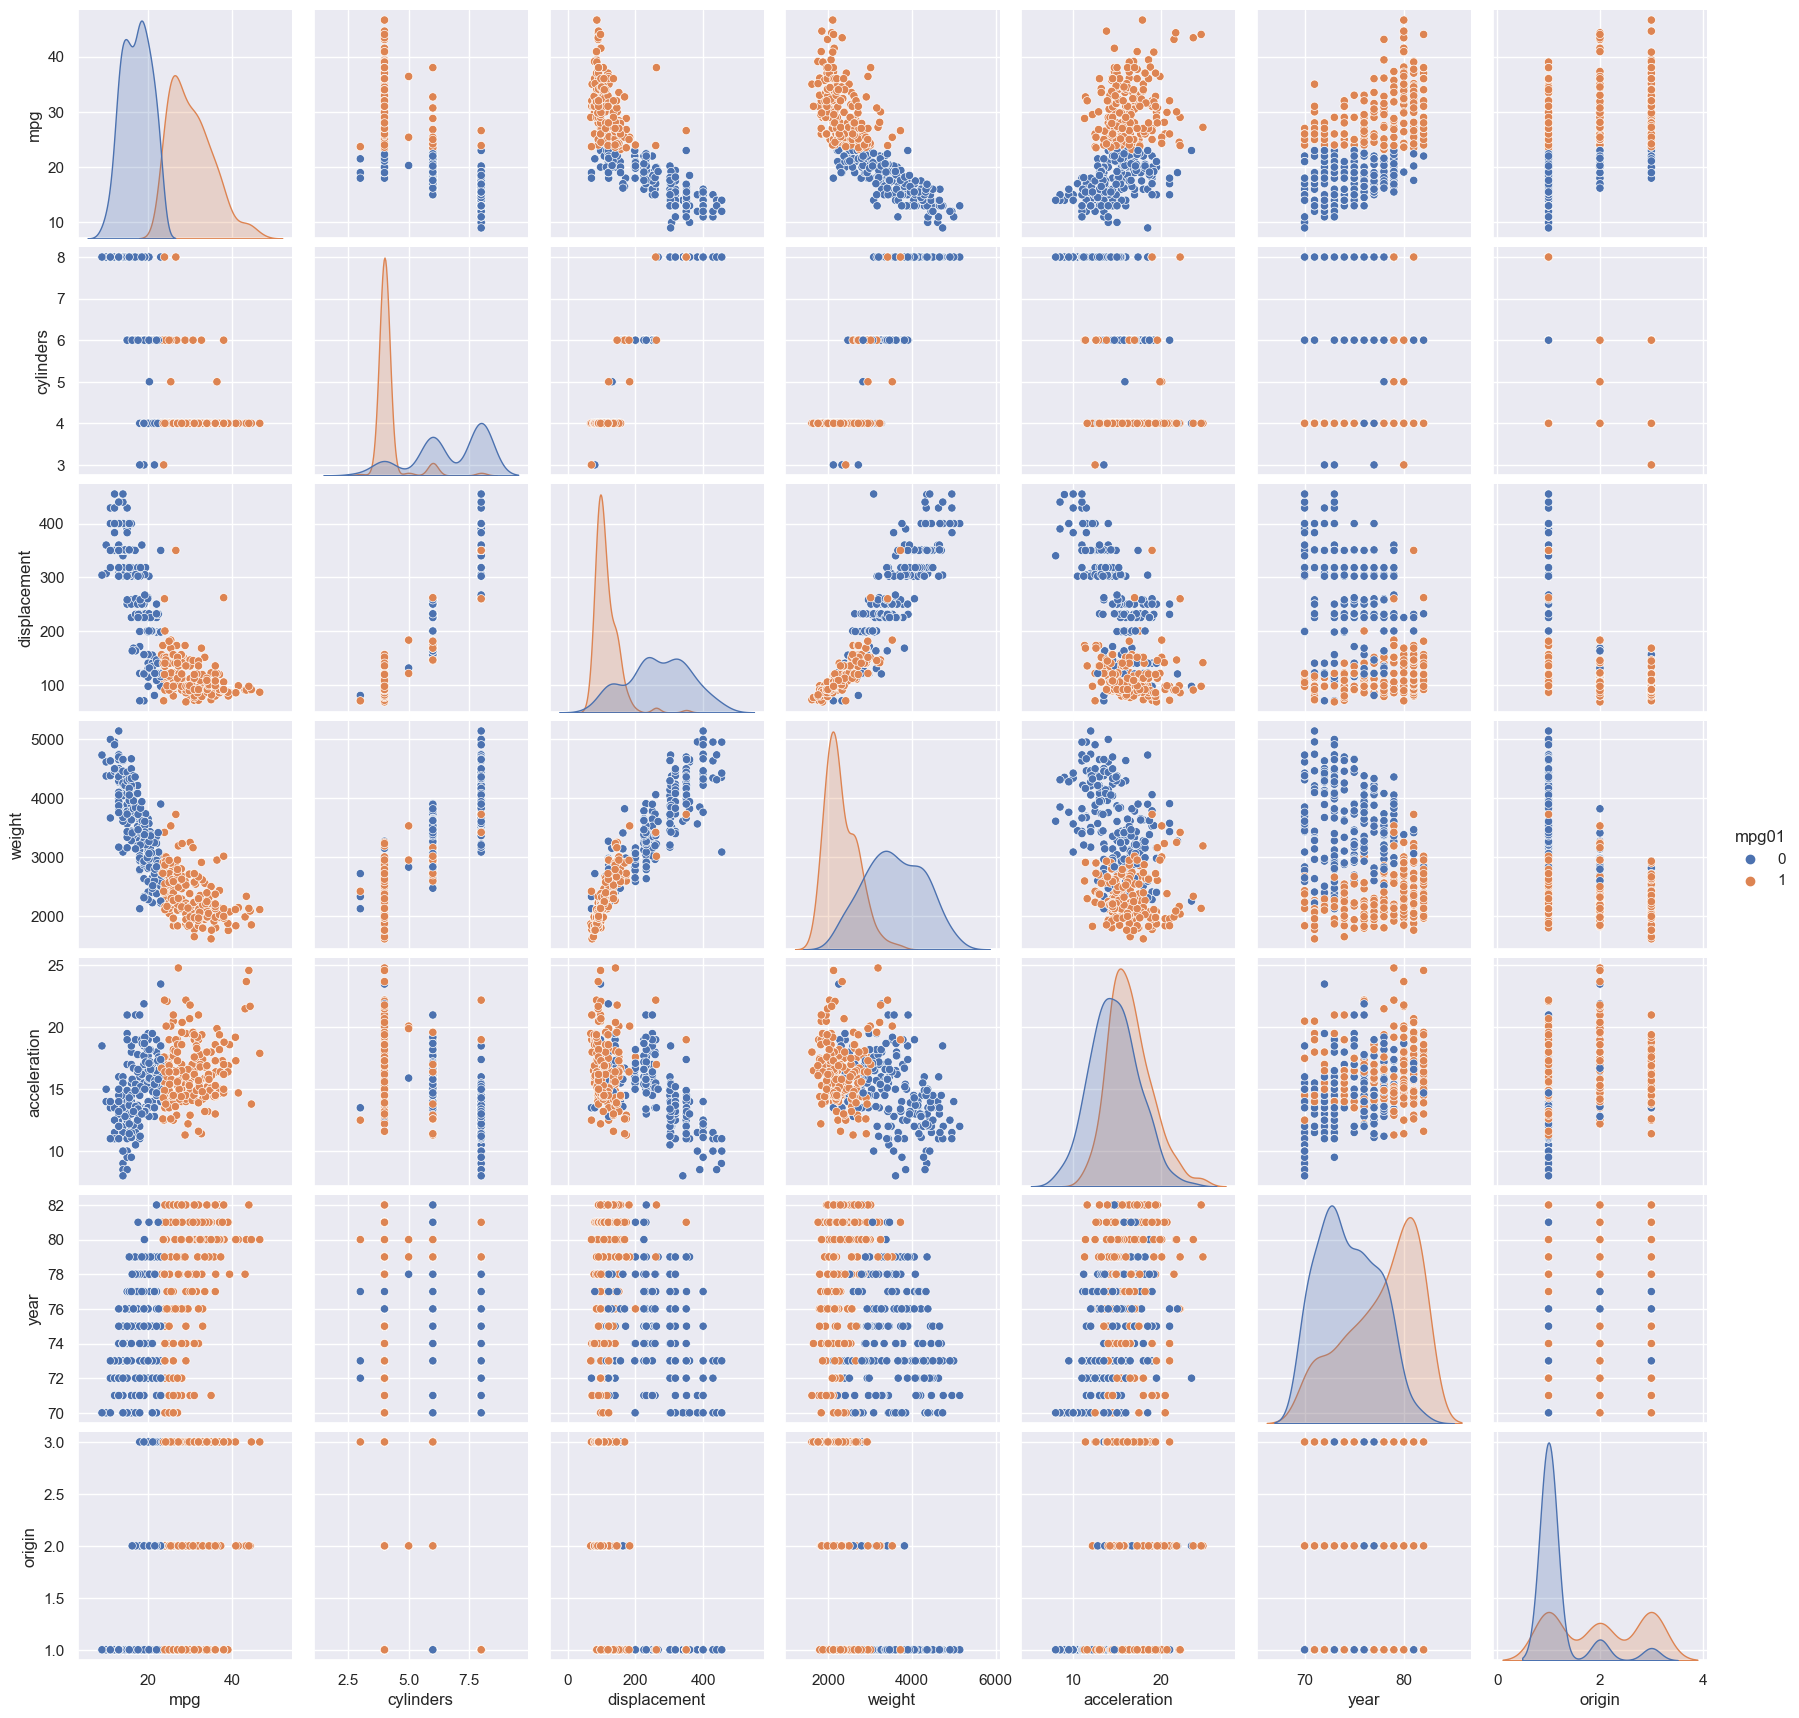

In [84]:
sns.pairplot(auto, hue="mpg01")

In [85]:
print(auto['horsepower'].dtype)

object


In [86]:
auto['horsepower'] = pd.to_numeric(auto['horsepower'], errors='coerce')

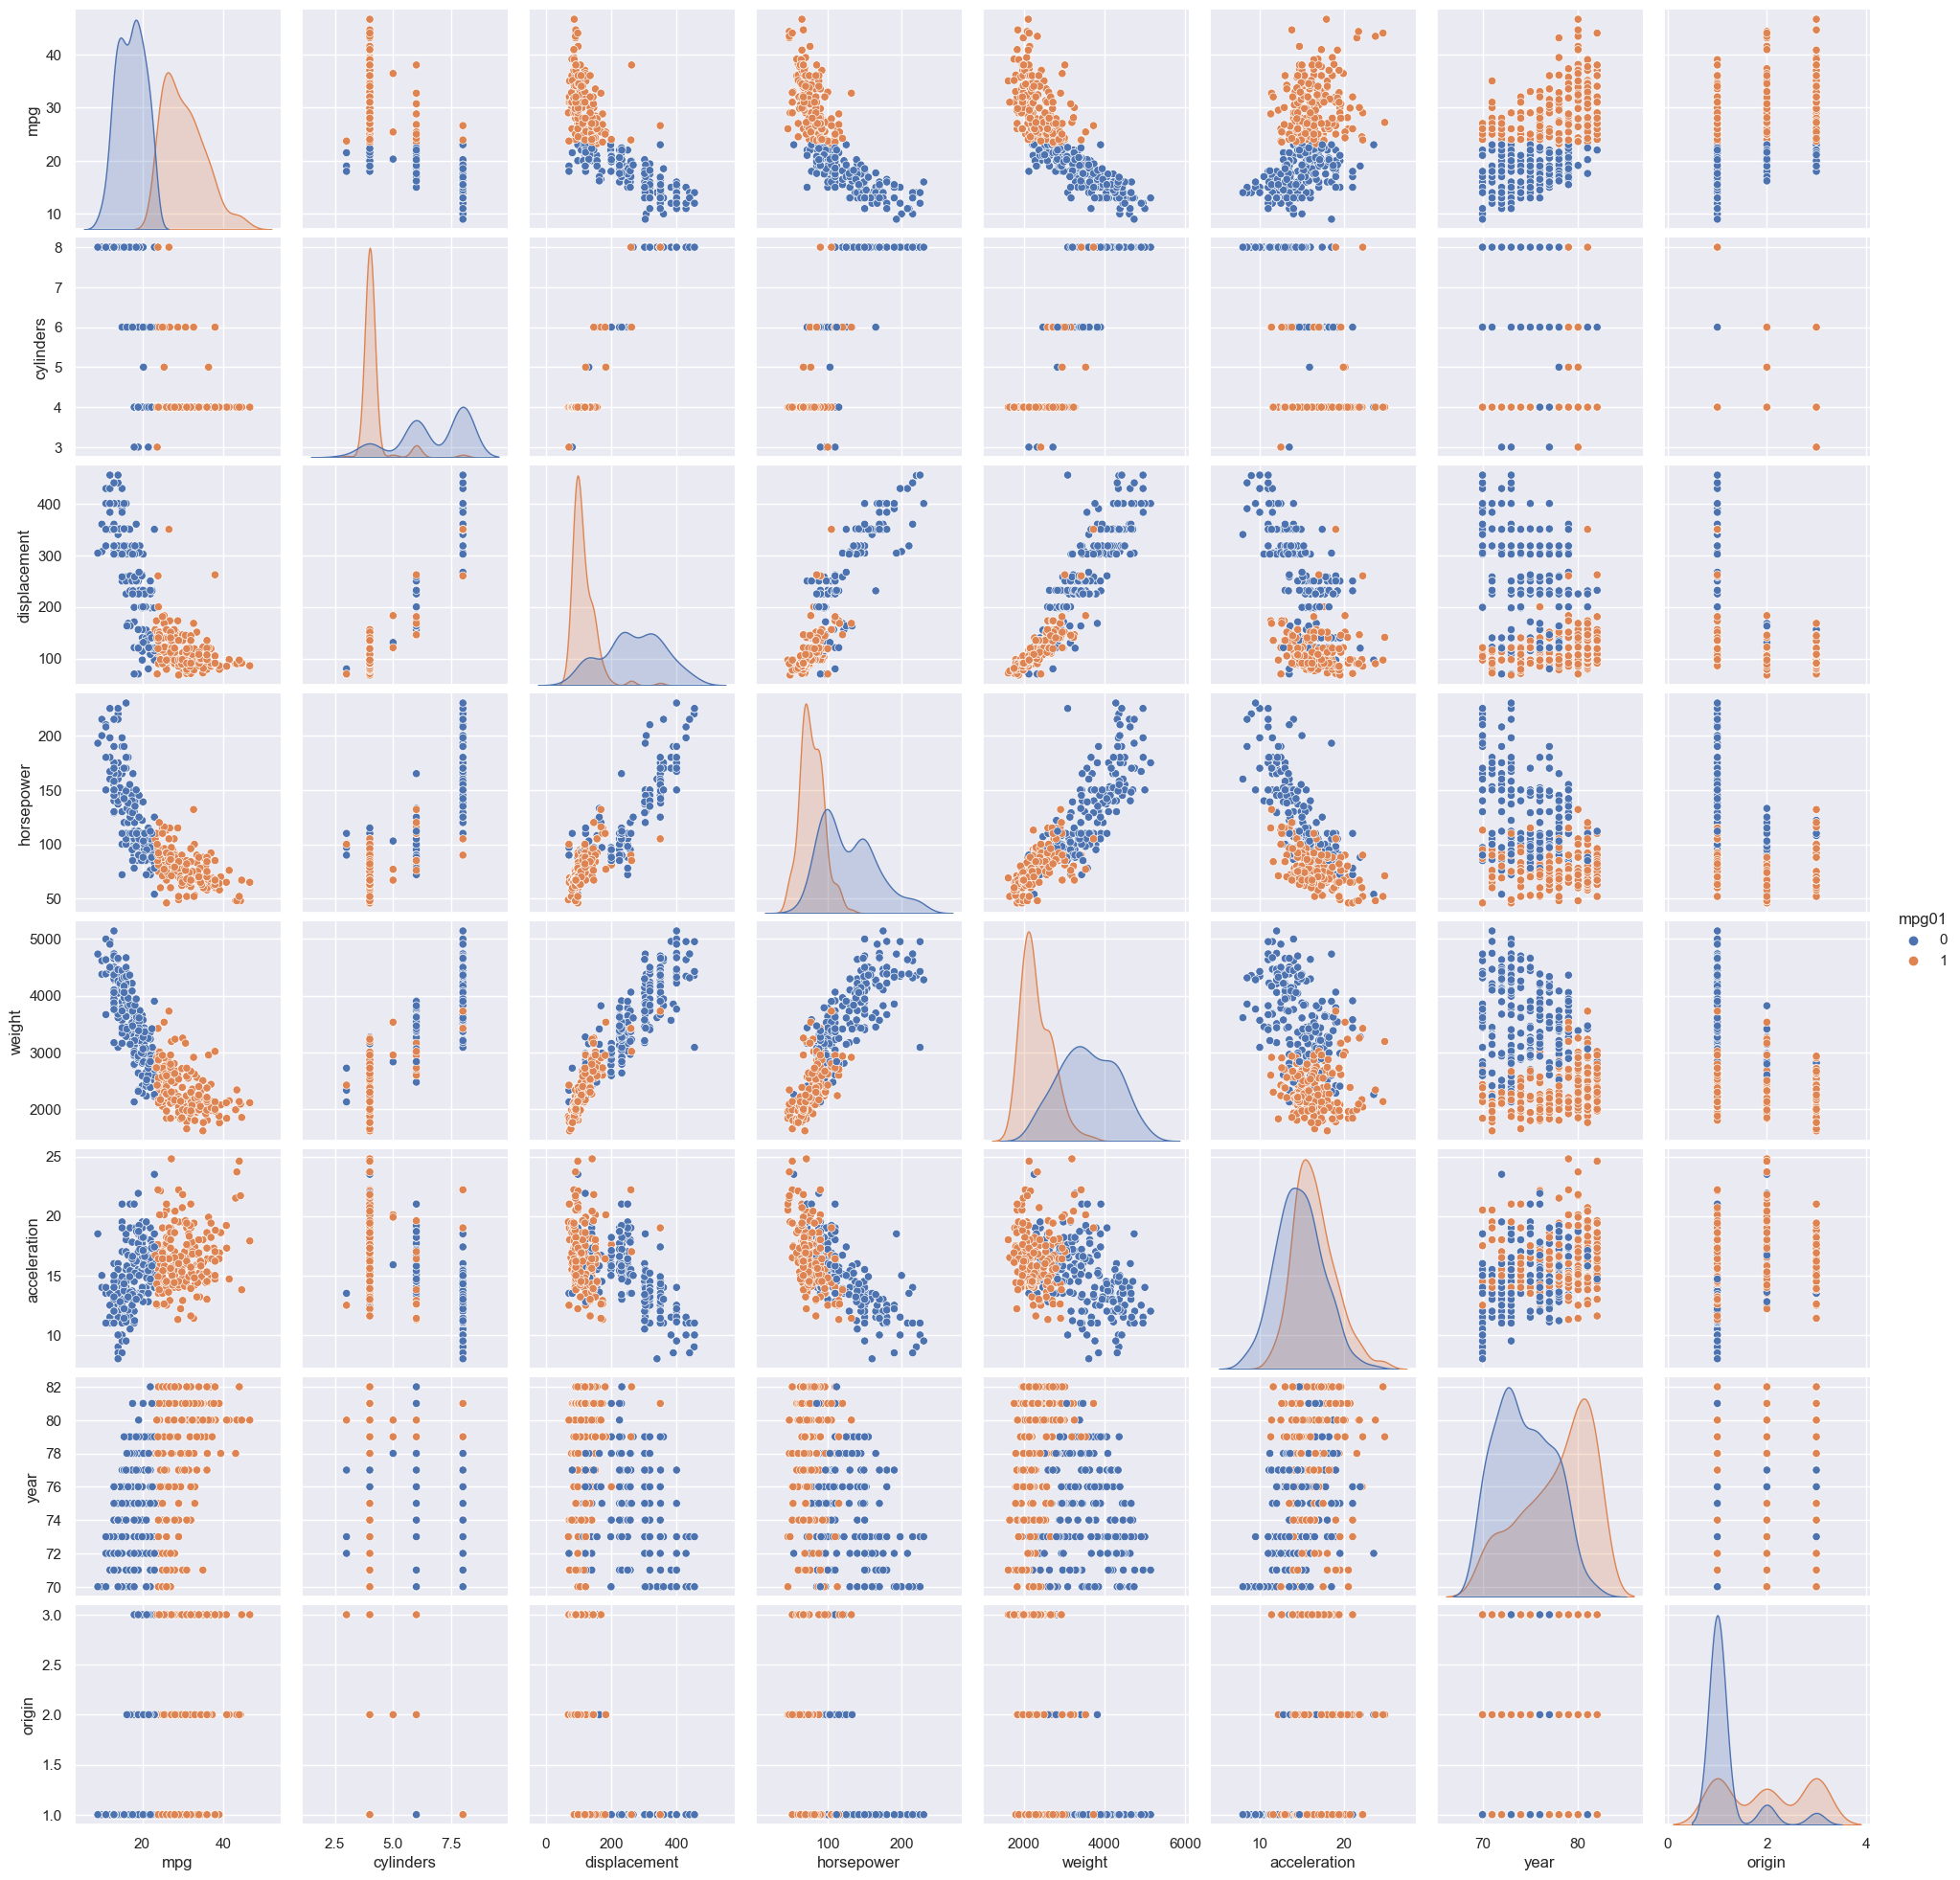

In [87]:
sns.pairplot(auto, hue="mpg01")

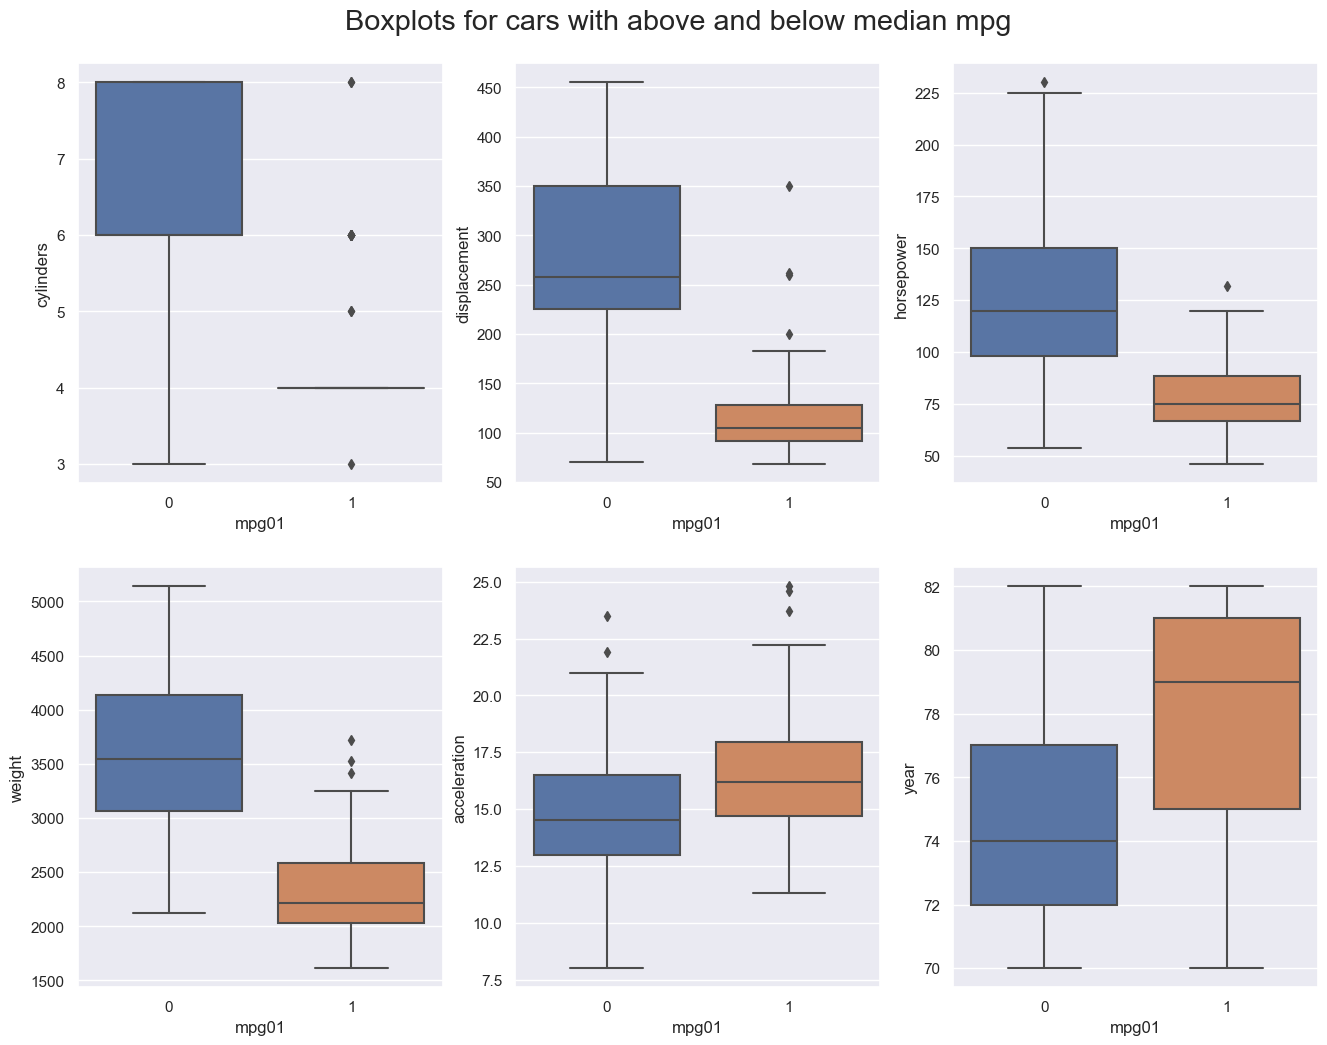

In [128]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 12))
sns.boxplot(x = "mpg01", y = "cylinders", data = auto, ax = axes[0, 0])
sns.boxplot(x = "mpg01", y = "displacement", data = auto, ax = axes[0, 1])
sns.boxplot(x = "mpg01", y = "horsepower", data = auto, ax = axes[0, 2])
sns.boxplot(x = "mpg01", y = "weight", data = auto, ax = axes[1, 0])
sns.boxplot(x = "mpg01", y = "acceleration", data = auto, ax = axes[1, 1])
sns.boxplot(x = "mpg01", y = "year", data = auto, ax = axes[1, 2])
fig.suptitle("Boxplots for cars with above and below median mpg", size = "xx-large", y = 0.925);

### This suggests that cylinders, displacement, horsepower, and weight will be the most useful in predicting mpg01.

#### (c) Split the data into a training set and a test set.

In [183]:
from sklearn.model_selection import train_test_split

# a convenient function for splitting data sets
X_train, X_test, y_train, y_test = train_test_split(auto, auto["mpg01"], test_size = 0.25, random_state = 312)

(d) Perform LDA on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

In [137]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

categorical_features = ["origin"]
categorical_transformer = Pipeline([("onehot", OneHotEncoder(drop = "first"))])
numerical_features = ["cylinders", "displacement", "horsepower", "weight", "year"]
preprocessor = ColumnTransformer([("cat", categorical_transformer, categorical_features),
                                 ("num", "passthrough", numerical_features)])
clf = Pipeline([("preprocessor", preprocessor), ("classifier", LinearDiscriminantAnalysis())])

/Users/nupoor/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


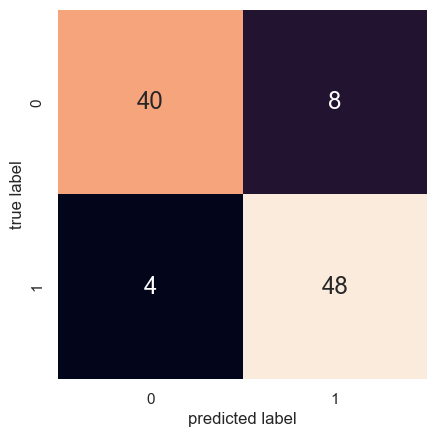

In [157]:
## the code was giving an eroor stating there were missing valuesin data. Hnece, dropped NAs.

# Drop rows with missing values from both X_train and y_train
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

# Drop rows with missing values from X_test
X_test = X_test.dropna()

# Now you can fit the classifier and make predictions
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");


In [147]:
1 - clf.score(X_test, y_test)

0.13

In [148]:
# Exclude the origin and year columns
categorical_features = []
categorical_transformer = Pipeline([("onehot", OneHotEncoder(drop = "first"))])
numerical_features = ["cylinders", "displacement", "horsepower", "weight"]
preprocessor = ColumnTransformer([("cat", categorical_transformer, categorical_features),
                                 ("num", "passthrough", numerical_features)])
clf = Pipeline([("preprocessor", preprocessor), ("classifier", LinearDiscriminantAnalysis())])

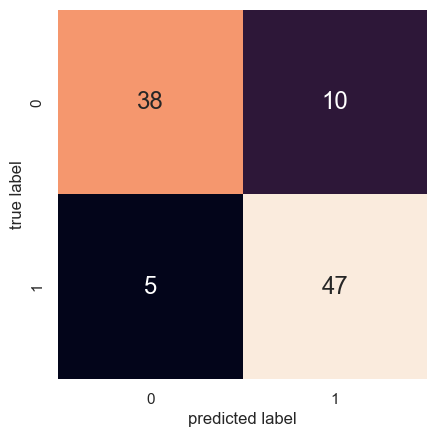

In [149]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [150]:
1 - clf.score(X_test, y_test)

0.15000000000000002

#### (e) Perform QDA on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

In [151]:
categorical_features = ["origin"]
categorical_transformer = Pipeline([("onehot", OneHotEncoder(drop = "first"))])
numerical_features = ["cylinders", "displacement", "horsepower", "weight", "year"]
preprocessor = ColumnTransformer([("cat", categorical_transformer, categorical_features),
                                 ("num", "passthrough", numerical_features)])
clf = Pipeline([("preprocessor", preprocessor), ("classifier", QuadraticDiscriminantAnalysis())])


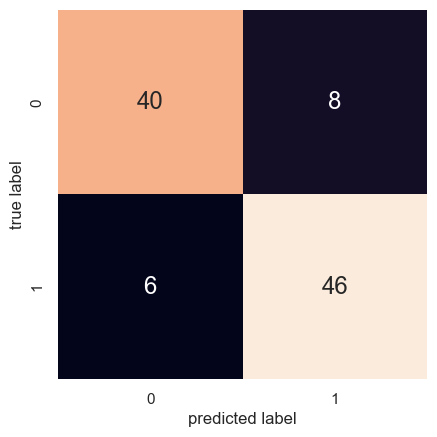

In [152]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [153]:
1 - clf.score(X_test, y_test)

0.14

#### (f) Perform logistic regression on the training data in order to pre- dict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

In [154]:
categorical_features = ["origin"]
categorical_transformer = Pipeline([("onehot", OneHotEncoder(drop = "first"))])
numerical_features = ["cylinders", "displacement", "horsepower", "weight", "year"]
preprocessor = ColumnTransformer([("cat", categorical_transformer, categorical_features),
                                 ("num", "passthrough", numerical_features)])
clf = Pipeline([("preprocessor", preprocessor), 
                ("classifier", LogisticRegression(penalty = "none", solver = "lbfgs"))])

/Users/nupoor/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


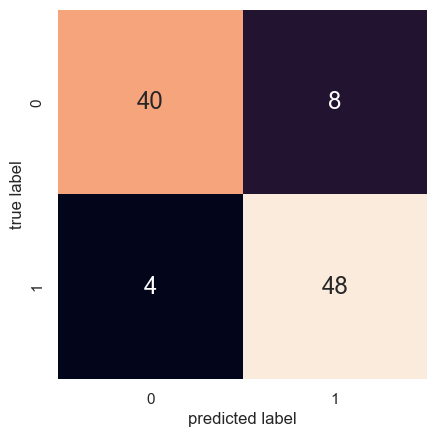

In [155]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [156]:
1 - clf.score(X_test, y_test)

0.12

In [167]:
# dropping NAs

auto= pd.read_csv('Auto.csv', na_values='?').dropna()
mpg_median = auto['mpg'].median()

# Create a binary variable 'mpg01'
auto['mpg01'] = (auto['mpg'] > mpg_median).astype(int)

# Display the first few rows of the updated dataset
print(auto.head())

    mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0       130.0    3504          12.0    70   
1  15.0          8         350.0       165.0    3693          11.5    70   
2  18.0          8         318.0       150.0    3436          11.0    70   
3  16.0          8         304.0       150.0    3433          12.0    70   
4  17.0          8         302.0       140.0    3449          10.5    70   

   origin                       name  mpg01  
0       1  chevrolet chevelle malibu      0  
1       1          buick skylark 320      0  
2       1         plymouth satellite      0  
3       1              amc rebel sst      0  
4       1                ford torino      0  


#### (g) Perform naive Bayes on the training data in order to predict mpg01 using the variables that seemed most associated with mpg01 in (b). What is the test error of the model obtained?

In [182]:
from sklearn.naive_bayes import GaussianNB

X = auto.drop(['mpg','mpg01', 'name'], axis=1)
y = auto['mpg01']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=312)

# Perform Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

# Calculate test error
test_error_nb = 1 - accuracy_score(y_test, y_pred_nb)
test_error_nb

0.07594936708860756

#### (h) Perform KNN on the training data, with several values of K, in order to predict mpg01. Use only the variables that seemed most associated with mpg01 in (b). What test errors do you obtain? Which value of K seems to perform the best on this data set?

In [184]:
numerical_features = ["cylinders", "displacement", "horsepower", "weight", "year"]
numerical_transformer = Pipeline([("standardize", StandardScaler())])
preprocessor = ColumnTransformer([("num", numerical_transformer, numerical_features)])

np.random.seed(312)
k_vals = list(range(1, 21, 2))
knn_errors = {}
confusion_matrices = {}
for k in k_vals:
    clf = Pipeline([("preprocessor", preprocessor), ("classifier", KNeighborsClassifier(n_neighbors = k))])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confusion_matrices[k] = confusion_matrix(y_test, y_pred)
    knn_errors[k] = 1 - clf.score(X_test, y_test)
pd.Series(knn_errors)

1     0.081633
3     0.081633
5     0.081633
7     0.091837
9     0.091837
11    0.102041
13    0.081633
15    0.081633
17    0.081633
19    0.081633
dtype: float64

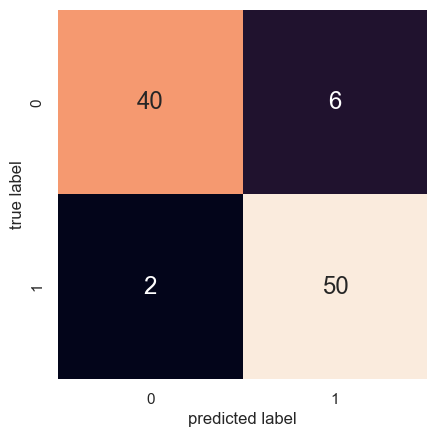

In [185]:
mat = confusion_matrices[pd.Series(knn_errors).idxmin()]
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

## 16. Using the Boston data set, fit classification models in order to predict whether a given suburb has a crime rate above or below the median. Explore logistic regression, LDA, naive Bayes, and KNN models using various subsets of the predictors. Describe your findings.
Hint: You will have to create the response variable yourself, using the variables that are contained in the Boston data set.

In [193]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Load the Boston dataset
boston_file = "https://raw.githubusercontent.com/namiyousef/ai_hack_2021/main/data/Boston_Housing_Market_Challenge/boston_fixed.csv"
index_cols = ["TOWN", "TRACT"]
data_cols = ["TOWN", "TRACT", "CMEDV", "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX",
            "PTRATIO", "B", "LSTAT"]
boston = pd.read_csv(boston_file, index_col = index_cols, usecols = data_cols)
boston.head()

CMEDV     CRIM   ZN  INDUS  CHAS   NOX     RM   AGE     DIS  \
TOWN      TRACT                                                                
Arlington 3567    29.9  0.06642  0.0   4.05     0  0.51  6.860  74.4  2.9153   
          3566    24.6  0.05425  0.0   4.05     0  0.51  6.315  73.4  3.3175   
          3565    23.2  0.07022  0.0   4.05     0  0.51  6.020  47.2  3.5549   
          3564    29.4  0.06664  0.0   4.05     0  0.51  6.546  33.1  3.1323   
          3563    22.6  0.08447  0.0   4.05     0  0.51  5.859  68.7  2.7019   

                 RAD  TAX  PTRATIO       B  LSTAT  
TOWN      TRACT                                    
Arlington 3567     5  296     16.6  391.27   6.92  
          3566     5  296     16.6  395.60   6.29  
          3565     5  296     16.6  393.23  10.11  
          3564     5  296     16.6  390.96   5.33  
          3563     5  296     16.6  393.23   9.64

In [195]:
boston.describe()

,CMEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,22.528854,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,9.182176,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,5.000000,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,17.025000,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,21.200000,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,25.000000,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,50.000000,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [197]:
# Drop missing values if needed
boston = boston.dropna()

crim_med = (boston["CRIM"] > boston["CRIM"].median()).map({False: "Below", True: "Above"})
boston["crim_med"] = crim_med

In [198]:
boston.corr()["CRIM"]

/var/folders/8n/fkhnz2dj2q3c9g5bcrv652n40000gn/T/ipykernel_48868/3769878102.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  boston.corr()["CRIM"]


CMEDV     -0.389582
CRIM       1.000000
ZN        -0.200469
INDUS      0.406583
CHAS      -0.055892
NOX        0.420972
RM        -0.219247
AGE        0.352734
DIS       -0.379670
RAD        0.625505
TAX        0.582764
PTRATIO    0.289946
B         -0.385064
LSTAT      0.455621
Name: CRIM, dtype: float64

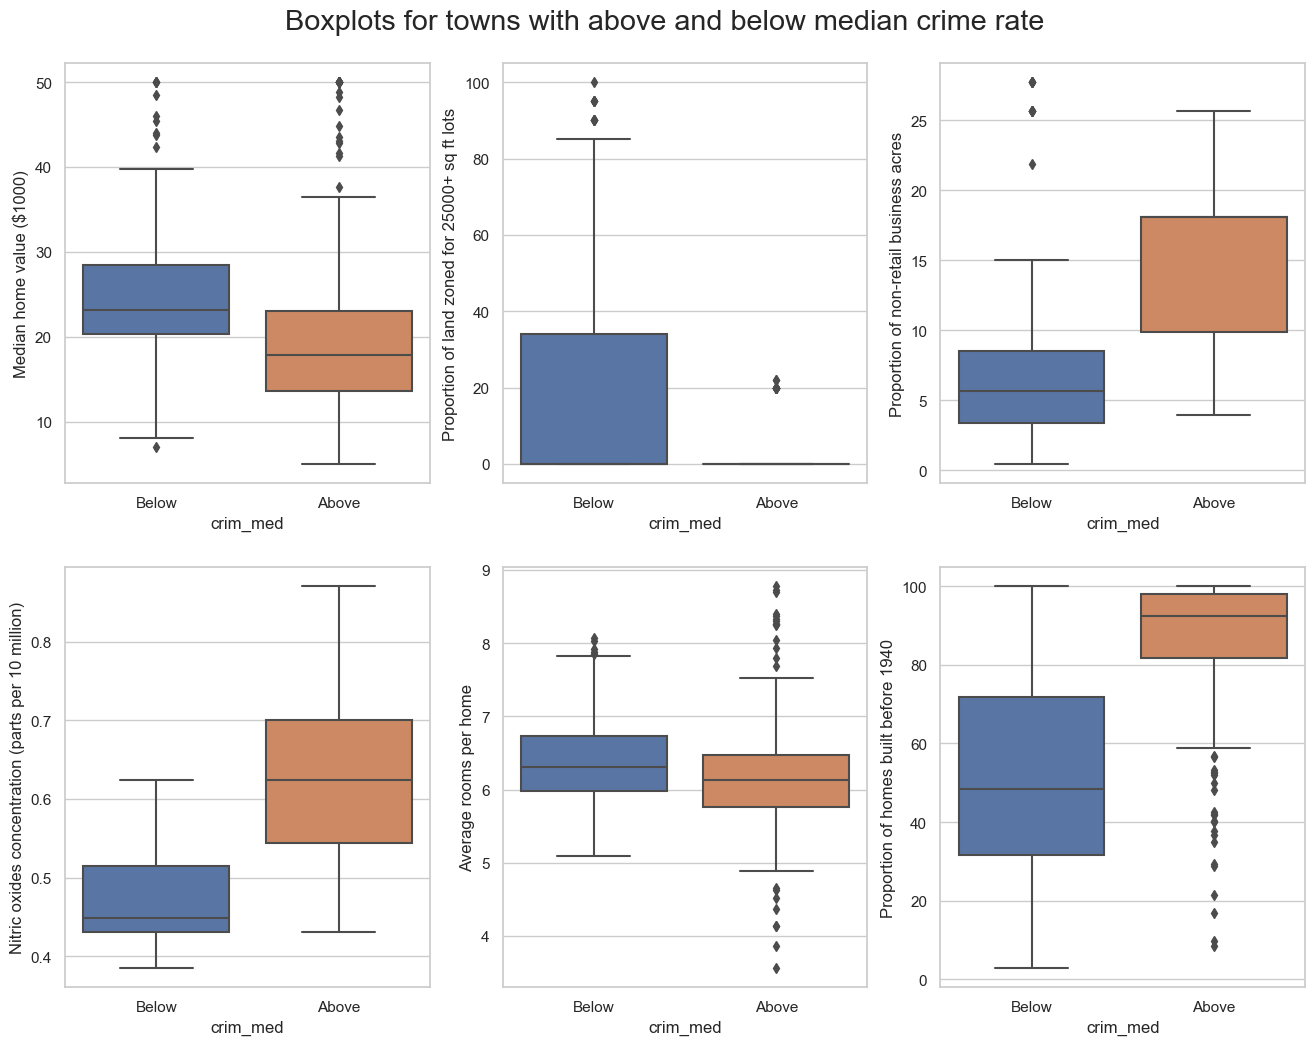

In [202]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 12))
sns.set_theme(style="ticks")
sns.boxplot(x = "crim_med", y = "CMEDV", data = boston, ax = axes[0, 0])
axes[0, 0].set_ylabel("Median home value ($1000)")
sns.boxplot(x = "crim_med", y = "ZN", data = boston, ax = axes[0, 1])
axes[0, 1].set_ylabel("Proportion of land zoned for 25000+ sq ft lots")
sns.boxplot(x = "crim_med", y = "INDUS", data = boston, ax = axes[0, 2])
axes[0, 2].set_ylabel("Proportion of non-retail business acres")
sns.boxplot(x = "crim_med", y = "NOX", data = boston, ax = axes[1, 0])
axes[1, 0].set_ylabel("Nitric oxides concentration (parts per 10 million)")
sns.boxplot(x = "crim_med", y = "RM", data = boston, ax = axes[1, 1])
axes[1, 1].set_ylabel("Average rooms per home")
sns.boxplot(x = "crim_med", y = "AGE", data = boston, ax = axes[1, 2])
axes[1, 2].set_ylabel("Proportion of homes built before 1940")
fig.suptitle("Boxplots for towns with above and below median crime rate", size = "xx-large", y = 0.925);

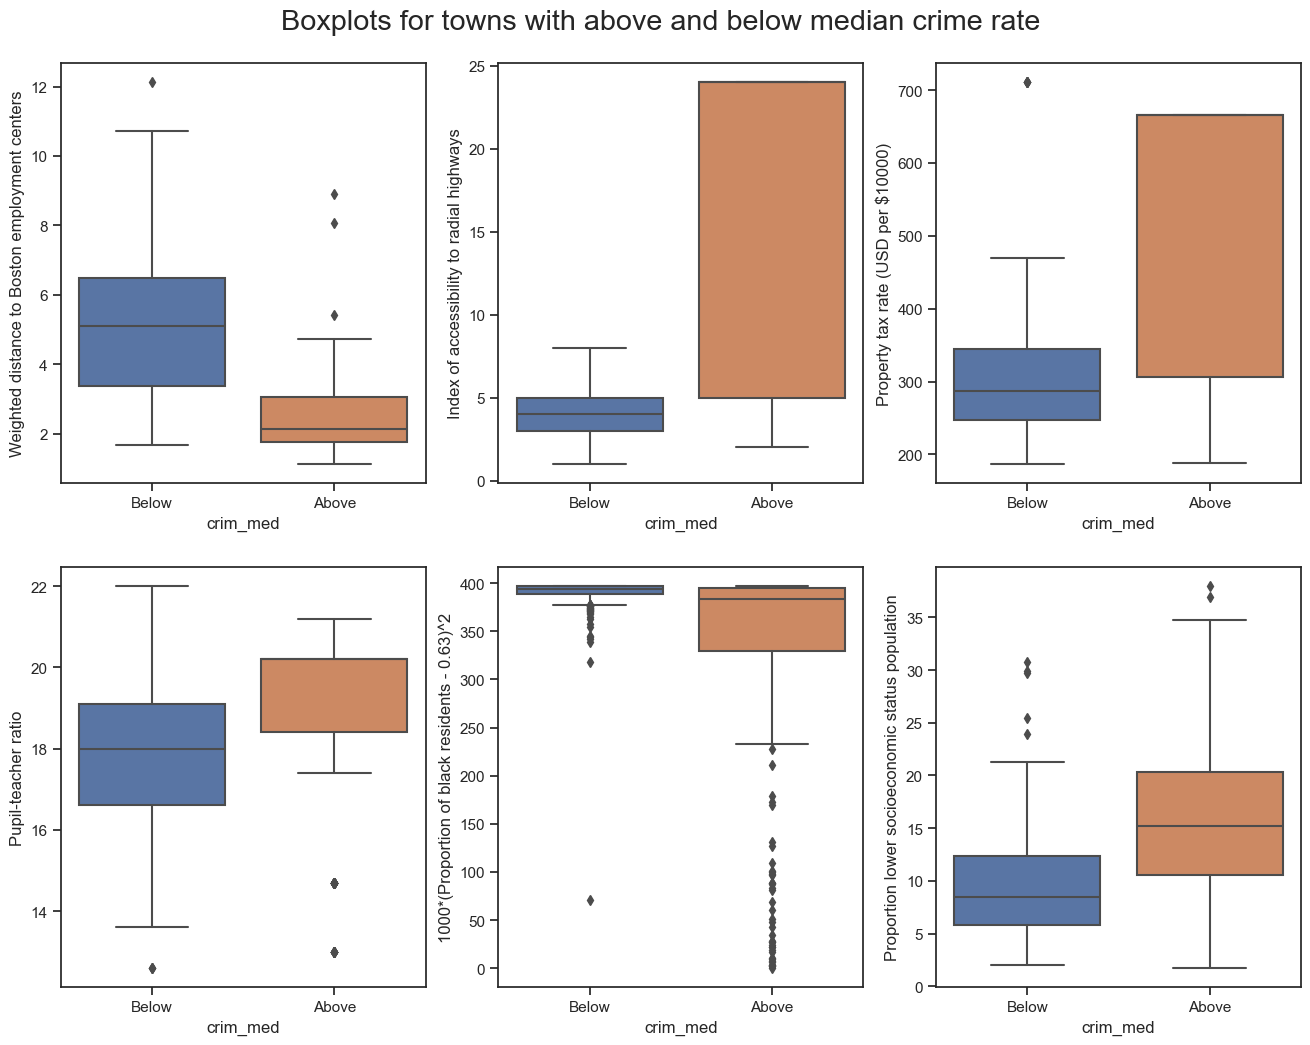

In [203]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 12))
sns.boxplot(x = "crim_med", y = "DIS", data = boston, ax = axes[0, 0])
axes[0, 0].set_ylabel("Weighted distance to Boston employment centers")
sns.boxplot(x = "crim_med", y = "RAD", data = boston, ax = axes[0, 1])
axes[0, 1].set_ylabel("Index of accessibility to radial highways")
sns.boxplot(x = "crim_med", y = "TAX", data = boston, ax = axes[0, 2])
axes[0, 2].set_ylabel("Property tax rate (USD per $10000)")
sns.boxplot(x = "crim_med", y = "PTRATIO", data = boston, ax = axes[1, 0])
axes[1, 0].set_ylabel("Pupil-teacher ratio")
sns.boxplot(x = "crim_med", y = "B", data = boston, ax = axes[1, 1])
axes[1, 1].set_ylabel("1000*(Proportion of black residents - 0.63)^2")
sns.boxplot(x = "crim_med", y = "LSTAT", data = boston, ax = axes[1, 2])
axes[1, 2].set_ylabel("Proportion lower socioeconomic status population")
fig.suptitle("Boxplots for towns with above and below median crime rate", size = "xx-large", y = 0.925);

In [204]:
X_train, X_test, y_train, y_test = train_test_split(boston, boston["crim_med"], test_size = 0.25, random_state = 312)

In [230]:
not_chas = boston.columns.drop(["CHAS", "CRIM", "crim_med"])
moderate_corr = boston.corr().loc[(boston.corr()["CRIM"].abs() > 0.3), "CRIM"].index.drop("CRIM")

/var/folders/8n/fkhnz2dj2q3c9g5bcrv652n40000gn/T/ipykernel_48868/3407009205.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  moderate_corr = boston.corr().loc[(boston.corr()["CRIM"].abs() > 0.3), "CRIM"].index.drop("CRIM")


/Users/nupoor/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


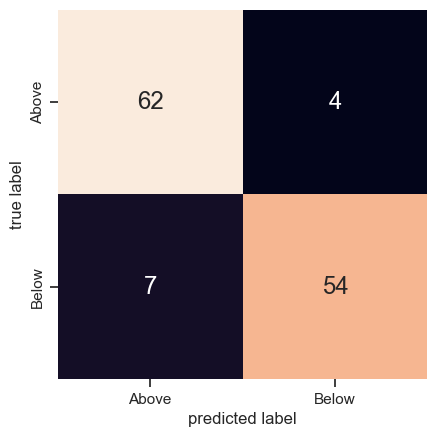

In [206]:
clf = LogisticRegression(penalty = "none", solver = "lbfgs", max_iter = 10000)
clf.fit(X_train[not_chas], y_train)
y_pred = clf.predict(X_test[not_chas])
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [207]:
1 - clf.score(X_test[not_chas], y_test)

0.08661417322834641

/Users/nupoor/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


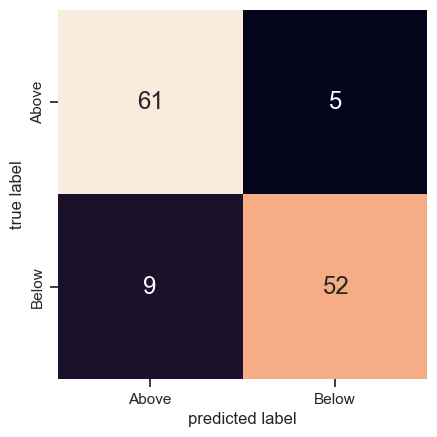

In [208]:
clf = LogisticRegression(penalty = "none", solver = "lbfgs", max_iter = 10000)
clf.fit(X_train[moderate_corr], y_train)
y_pred = clf.predict(X_test[moderate_corr])
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

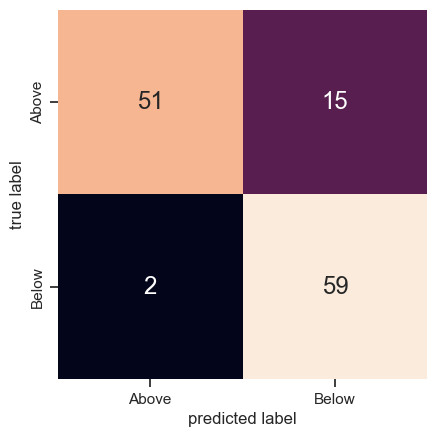

In [209]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train[not_chas], y_train)
y_pred = clf.predict(X_test[not_chas])
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [210]:
1 - clf.score(X_test[not_chas], y_test)

0.13385826771653542

#### After changing the predictors the score has increased from 8% to 13% which is not good.

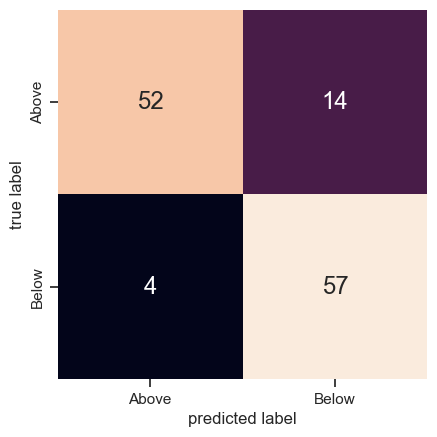

In [211]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train[moderate_corr], y_train)
y_pred = clf.predict(X_test[moderate_corr])
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [212]:
1 - clf.score(X_test[moderate_corr], y_test)

0.1417322834645669

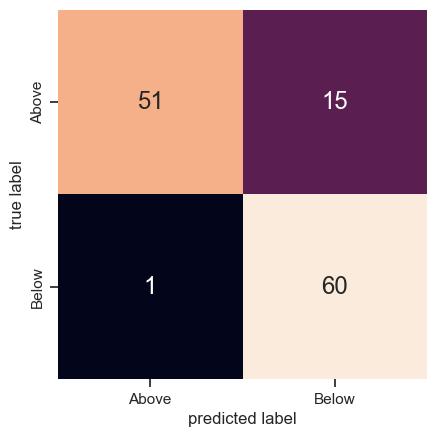

In [213]:
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train[not_chas], y_train)
y_pred = clf.predict(X_test[not_chas])
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");


In [214]:
1 - clf.score(X_test[not_chas], y_test)

0.12598425196850394

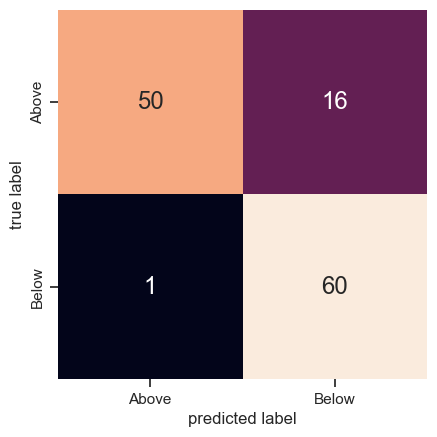

In [215]:

clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train[moderate_corr], y_train)
y_pred = clf.predict(X_test[moderate_corr])
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [216]:
1 - clf.score(X_test[moderate_corr], y_test)

0.13385826771653542

In [217]:
np.random.seed(312)
k_vals = list(range(1, 21, 2))
knn_errors = {}
confusion_matrices = {}
for k in k_vals:
    clf = Pipeline([("standardize", StandardScaler()), ("classifier", KNeighborsClassifier(n_neighbors = k))])
    clf.fit(X_train[not_chas], y_train)
    y_pred = clf.predict(X_test[not_chas])
    confusion_matrices[k] = confusion_matrix(y_test, y_pred)
    knn_errors[k] = 1 - clf.score(X_test[not_chas], y_test)
pd.Series(knn_errors)

1     0.062992
3     0.070866
5     0.070866
7     0.062992
9     0.062992
11    0.086614
13    0.094488
15    0.110236
17    0.141732
19    0.173228
dtype: float64

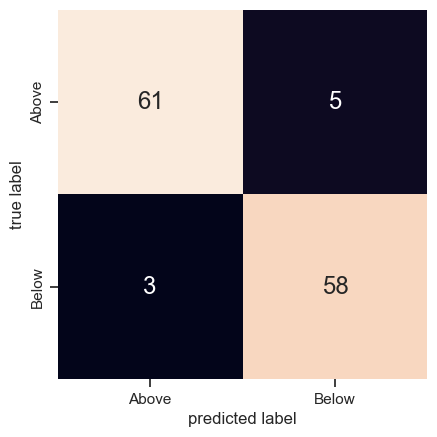

In [218]:
mat = confusion_matrices[1]
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

While further metrics and cross-validation are necessary for confident model selection, two leading contenders emerge: logistic regression and k-nearest neighbors (KNN). Logistic regression offers simplicity and interpretability compared to KNN, with slightly higher test error but reasonable performance. On the other hand, KNN boasts lower overall test error and superior positive predictive value, particularly when logistic regression's threshold is 0.5.